<a href="https://colab.research.google.com/github/adamelsais/projects/blob/main/Elsais_adam_Comp360.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project Layout  

### Summary: Empowering Stock Market Investors

* **Objective:** Simplify stock market investing for new/casual investors, fostering confidence in understanding market sentiment (bullish/bearish trends).

* **Approach:** Utilize S&P 500 component stocks to predict movements in the SPY ETF, a key indicator of market sentiment.

* **Goals:**

 * Implement parallelization and optimization techniques for efficient processing.
 * Develop a stock price predictor focused on the SPY ETF for accurate market trend forecasting.
 * Create intuitive visualizations to enhance users' confidence and understanding.
 * By combining data analysis, predictive modeling, and user-friendly visuals, our project aims to equip investors with the tools and insights needed to navigate the stock market with confidence.


---


###Webscrape:
We will webscrape the list of S&P 500 component stocks from Wikipedia so we can have all the Ticker symbols in one dataframe.Only scraping and storing the ticker symbols.

---

### Collect Data:
We will use yfinance library to access Yahoo's publicly available APIs. We will iterate through all the Ticker symbols we previously collected, and store each stock's historical data in one dataframe. We will utilize joblib to parallelize fetching the data in order to promote speedup.

---

### Clean Data:
We will need to add to the dataframe whether the S&P 500 was bearish/bullish on that day, as well as if the individual stock was. We will do this by comparing the previous trading day's Close price to the next day's. Make a Target column which will be a Bool (0 or 1) to decide if we should invest in the S&P 500. Other parts of cleaning our data is giving each DataFrame a name, and making sure our spy df has a 'Dates' column.

---

### Machine Learning Models:
1. Model 1: Bull/Bear
  * Main model and goal of this project is to determine whether or not we can use the S&P 500 component stocks to accurately predict whether SPY is bullish or bearish, which also can help us predict the overall stock market.
  * We will use a Random Forest Classification Machine Learning Model, where we parallelize our model with every single ticker.
  * Our first usage is the S&P 500 component stocks: where we ultimately want to see the average accuracy for all 500 stocks.
  * Our second usage is purely with the SPY ETF: where we return the accuracy.
  * We can compared how accurate our model is at predicting the two and can determine how confident we can be using our model.
2. Model 2: Price Prediction
  * A model that we decided to try out for the fun of it. We will utilize a LSTM ML model that will be able to predict a stock's price during a given time period.
  * The model essentially prepares historical data, creates a windowed dataset for training, builds and trains an LSTM-based model for predicting the SPY ETF price, and evaluates the model's performance using different datasets.

---

###Visualizations:
1. Model 1: Bull/Bear -
* SPY accuracy Bar Chart:
  * The proportion_graph function calculates and compares the proportions of two categories (Bull/Bear) between actual and predicted values in a DataFrame.
  * Creates a grouped bar chart to visualize this comparison, with labels for categories, proportions on the y-axis, and a title indicating the comparison.
  * The function provides a clear visual representation of how well the predictions align with the actual data, aiding in evaluating the model's performance in predicting market sentiment.


2. Model 2: Price Prediction -
* Training Predictions vs. Observations:

  *   Plots the model's predictions and the actual observed values for the training dataset.
  *   Helps visualize how well the model fits the training data.

* Validation Predictions vs. Observations:

  * Displays the model's predictions and the actual observed values for the validation dataset.
  * Aids in understanding the model's generalization performance on unseen
  
* Testing Predictions vs. Observations:

  * Shows the model's predictions and the actual observed values for the testing dataset.
  * Assists in assessing the model's predictive accuracy on completely new, unseen data (testing set).

* Combined Plot:

  * Combines the training, validation, and testing predictions and observations into a single plot.
  * Offers a comparative view of how well the model performs across different datasets.


## Libraries needed

In [1]:
# import all libraries
# webscrape libraries
import bs4 as bs # pulling data out of HTML and XML files.
import urllib.request # opening and reading URLs
import requests
import re # pattern matching
import pandas as pd
import numpy as np
from time import sleep
import requests
# data libraries
import yfinance as yf
from joblib import Parallel, delayed
import time
import datetime
# metric libraries
from sklearn.ensemble import RandomForestClassifier
import sklearn.model_selection as ms
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn import metrics
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers


##Web scrape

Purely webscrape the Tickers of the SPY component stocks

In [2]:
#  URL of the Wikipedia page containing the S&P 500 component stocks
url = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"

# Fetch the HTML content of the page
response = requests.get(url)
soup = bs.BeautifulSoup(response.text, 'html.parser')

# Find the table containing the S&P 500 component stocks
table = soup.find('table', {'class': 'wikitable sortable'})

# Extract only ticker symbols from the table and store them in a list
ticker_symbols = []
rows = table.find_all('tr')
for row in rows[1:]:  # Skip the header row
    cols = row.find_all('td')
    ticker_symbols.append(cols[0].text.strip())

# Create a Pandas DataFrame from the ticker symbols list
sp500_tickers_df = pd.DataFrame({'Ticker': ticker_symbols})


## Data Collection


In [3]:
# SPY ETF data from yfinance in its own Dataframe

spy = yf.download("SPY",start="1993-01-29") # date is when SPY was initialized in the market


[*********************100%%**********************]  1 of 1 completed


In [4]:
# parallelize stock data collection
def fetch_data(ticker):
    #print(f"Fetching data for {ticker}...")
    data = yf.download(ticker, start="1993-01-29")
    if not data.empty:
        data['Ticker'] = ticker
    return data


In [5]:
# Parallel: fetch_data

# Parallelize data fetching
data_frames = Parallel(n_jobs=-1)(
    delayed(fetch_data)(ticker) for ticker in sp500_tickers_df['Ticker']
)


# Concatenate all individual DataFrames into a single DataFrame
all_data_parallel = pd.concat(data_frames)

# Reset index for the final DataFrame
all_data_parallel.reset_index(inplace=True)


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


## Clean Data


*   Add new column in our dataframe: Bull/Bear
  *   We will use the previous trading day's closing price and compare it with the current day's closing price.
  * This will be a bool value of 0 or 1

1. Smooths Out Intraday Volatility: By focusing on
closing prices, we are looking at the overall movement of the stock throughout the entire trading day, which can help smooth out the effects of intraday volatility.
2. Reflects Investor Sentiment Over Time: Changes in closing prices over consecutive days can reflect shifts in investor sentiment, buying or selling pressure, and overall market trends more accurately than just comparing opening and closing prices within a single day.
3. Considers After-Hours Trading: After-hours trading can impact opening prices, but it doesn't affect closing prices from one day to the next. Therefore, comparing closing prices avoids the influence of after-hours trading on your analysis.
4. Widely Accepted Practice: Many technical analysts and traders use daily closing prices as key data points for their analysis, making it a widely accepted and practiced method.




In [6]:
# Add new column to our dataframe
def add_bull_bear_col(df, close_column='Close'):
    """
    Add a 'bull/bear' column to the DataFrame based on the difference
    between the current day's close and the previous day's close.

    Parameters:
    df (DataFrame): Input DataFrame containing the 'Close' column.
    close_column (str): Name of the column containing closing prices.

    Returns:
    DataFrame: Updated DataFrame with the 'bull/bear' column added.
    """
    # Calculate the difference between current day's close and previous day's close
    df['Close_diff'] = df[close_column].diff()

    # Add a new column 'bull/bear' with 0 or 1 based on the difference
    df['Bull/Bear'] = (df['Close_diff'] > 0).astype(int)

    # Drop the 'Close_diff' column if not needed
    #df.drop('Close_diff', axis=1, inplace=True)


    return df

In [7]:
# add_bull_bear_col with our S&P 500 component stock data
all_data = add_bull_bear_col(all_data_parallel)

all_data.name = 'all_data'

In [8]:
# test with our SPY data
spy = add_bull_bear_col(spy)
# needed to add this for changes in my model to perform visualizations
spy['Ticker'] = 'SPY'
spy['Dates'] = spy[spy['Ticker'] == "SPY"].index[:]
spy.name = 'spy'

In [9]:
# update ticker only df that matches all tickers in yfinance dataset

sp500_tickers_df = pd.DataFrame({'Ticker': all_data["Ticker"]})

# Get unique tickers using the unique method
unique_tickers = sp500_tickers_df['Ticker'].unique()

# Convert unique_tickers array to a DataFrame
sp500_tickers_df = pd.DataFrame({'Ticker': unique_tickers})

# Display the unique tickers
sp500_tickers_df.head()

,Ticker
0,MMM
1,AOS
2,ABT
3,ABBV
4,ACN


##My ML models

* Model 1: Bull/Bear
* Model 2: Price Prediction


###Model 1 (Main): Bull/Bear

Uses selected features ('Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume') to predict 'Bull/Bear' of a stock.

model_setup: helper function to process_ticker; either uses a specific stock or the SPY ETF

process_ticker is our actual model function which uses the parameters: ticker, all_data. Processes a RandomForestClassifier model for the ticker within the all_data df.

We then parallelize this process using joblib's Parallel and go through all the tickers within the all_data df.

Returns accuracy score and classification report

Works fairly well


In [10]:
# general feature selection
selected_features = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
def select_features(df):
  return df[selected_features]

In [11]:
def model_setup(ticker, stock_df):
  one_stock = stock_df[stock_df['Ticker'] == ticker]
  X = select_features(one_stock)
  y = one_stock['Bull/Bear']
  return X, y


In [12]:
# Define a function to process each ticker in parallel
def process_ticker(ticker:str, df: pd.DataFrame, df_name: str):
    # Generate features (X) and labels (y) using model_setup function
    X, y = model_setup(ticker, df)

    # Split training and testing data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Define the pipeline with RandomForestClassifier
    spy_clf = Pipeline([('clf', RandomForestClassifier(random_state=5))])

    # Fit the pipeline on the training data
    spy_clf.fit(X_train, y_train)

    # Apply the trained model to the test data
    predicted = spy_clf.predict(X_test)
    if df_name == 'spy':
      # Get the dates for the test data
      dates_test = spy["Dates"][-len(y_test):]

      # Create a new DataFrame with the predicted values and dates
      predicted_df = pd.DataFrame({'Dates': dates_test, 'Predicted_Bull_Bear': predicted})

      # Merge the DataFrames based on the "Dates" column
      merged_df = pd.merge(spy, predicted_df, on=['Dates'], how='left')

      return ticker, metrics.accuracy_score(y_test, predicted), metrics.classification_report(y_test, predicted), merged_df
    else:

      # Return the ticker symbol and evaluation results
      return ticker, metrics.accuracy_score(y_test, predicted), metrics.classification_report(y_test, predicted)




In [13]:
# Define the list of tickers to process
tickers_list = sp500_tickers_df["Ticker"].tolist()

len(tickers_list)

501

####S&P 500 Component Stocks

Created a faster way of processing each ticker in parallel. Created batches of 10 tickers; total 51 batches; totaling 501 stocks. Before we just ran our 'results', which could not even finish running.

In [14]:
batch_size = 10

# Calculate the number of batches
num_batches = len(tickers_list) // batch_size
if len(tickers_list) % batch_size != 0:
    num_batches += 1

# Function to process a batch of tickers
def process_batch(batch_num):
    start_idx = batch_num * batch_size
    end_idx = min((batch_num + 1) * batch_size, len(tickers_list))
    batch_tickers = tickers_list[start_idx:end_idx]
    results = Parallel(n_jobs=-1)(
        delayed(process_ticker)(ticker, all_data, all_data.name) for ticker in batch_tickers
    )
    return results

# Process batches in parallel
all_results = []
for batch_num in range(num_batches):
    batch_results = process_batch(batch_num)
    all_results.extend(batch_results)

# At this point, all_results contains the results from processing all tickers in batches

In [15]:
all_accuracy = [result[1] for result in all_results]

# Print all_accuracy
print(all_accuracy)

[0.7373096446700508, 0.7753807106598984, 0.7277918781725888, 0.6993006993006993, 0.6594076655052264, 0.7550761421319797, 0.7658629441624365, 0.7937817258883249, 0.7182741116751269, 0.7337662337662337, 0.7024111675126904, 0.7267441860465116, 0.7578947368421053, 0.7549277266754271, 0.7501842299189388, 0.7448805460750854, 0.7178030303030303, 0.7493654822335025, 0.7472738935214881, 0.721327967806841, 0.6971830985915493, 0.7373096446700508, 0.7255334805003679, 0.8327814569536424, 0.7528259231348907, 0.7707889125799574, 0.7734771573604061, 0.7208121827411168, 0.748730964467005, 0.7172100075815011, 0.715698393077874, 0.7148936170212766, 0.7227157360406091, 0.7493654822335025, 0.7093908629441624, 0.7455583756345178, 0.7594306049822064, 0.7436548223350253, 0.7728426395939086, 0.7265228426395939, 0.7595177664974619, 0.6878980891719745, 0.7172557172557172, 0.7696700507614214, 0.7504990019960079, 0.7239847715736041, 0.742409402546523, 0.7595177664974619, 0.7741116751269036, 0.7880710659898477, 0.7

In [16]:
sum_all_accuracy = sum(all_accuracy)
avg_all_accuracy = sum_all_accuracy / len(all_accuracy)
# Print or use total_accuracy as needed
print("Average Accuracy of S&P 500 Component Stocks:", avg_all_accuracy)

Average Accuracy of S&P 500 Component Stocks: 0.7411388221501941


#### SPY ETF

In [17]:
# SPY process_ticker

ticker, accuracy, classification_report, merged_spy = process_ticker("SPY", spy, spy.name)

In [18]:
# Print the results
print("Ticker:", ticker)
print("SPY Accuracy:", accuracy)
print("Classification Report:")
print(classification_report)
print(merged_spy.shape)




Ticker: SPY
SPY Accuracy: 0.6821065989847716
Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.63      0.65       727
           1       0.70      0.72      0.71       849

    accuracy                           0.68      1576
   macro avg       0.68      0.68      0.68      1576
weighted avg       0.68      0.68      0.68      1576

(7878, 11)


### Model 1 (other): Bull/Bear

Very condensed version of Data Collection, Data Clean up, and ML model 1 all in a singular function (process_ticker2) which then uses concurrent.futures library to parallelize & speedup.

ProcessPoolExecutor() simplifies the process of parallelizing and managing concurrent execution of functions across multiple processes, which can improve performance for tasks that can be parallelized.

In theory, process_ticker2 should be a lot faster than my original setup (Data Collection - Model 1: Bull/Bear). Also, from tests on the first 10 tickers, the accuracies are fairly similar, not much loss or gained from either model.



---

Leaving this here, it runs and works well, but I think my original runs faster overall. Decided to comment the code out, but it is cool to take a look at and play with.


In [19]:
'''
import concurrent.futures
from sklearn.model_selection import StratifiedKFold

# Define a function to process each ticker
def process_ticker2(ticker):
    # Fetch data for the ticker
    data = yf.download(ticker, start="1993-01-29")

    if data.empty:
        return None
    # clean data
    data = add_bull_bear_col(data)

    # Generate features (X) and labels (y)
    X = select_features(data)
    y = data['Bull/Bear']

    # Split data for cross-validation
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    accuracies = []
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Define and train the classifier
        clf = RandomForestClassifier(random_state=5)
        clf.fit(X_train, y_train)

        # Evaluate accuracy
        accuracy = clf.score(X_test, y_test)
        accuracies.append(accuracy)

    return ticker, np.mean(accuracies), None  # Return accuracy only

'''


'\nimport concurrent.futures\nfrom sklearn.model_selection import StratifiedKFold\n\n# Define a function to process each ticker\ndef process_ticker2(ticker):\n    # Fetch data for the ticker\n    data = yf.download(ticker, start="1993-01-29")\n\n    if data.empty:\n        return None\n    # clean data\n    data = add_bull_bear_col(data)\n\n    # Generate features (X) and labels (y)\n    X = select_features(data)\n    y = data[\'Bull/Bear\']\n\n    # Split data for cross-validation\n    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)\n    accuracies = []\n    for train_index, test_index in skf.split(X, y):\n        X_train, X_test = X.iloc[train_index], X.iloc[test_index]\n        y_train, y_test = y.iloc[train_index], y.iloc[test_index]\n\n        # Define and train the classifier\n        clf = RandomForestClassifier(random_state=5)\n        clf.fit(X_train, y_train)\n\n        # Evaluate accuracy\n        accuracy = clf.score(X_test, y_test)\n        accuracies.appe

In [20]:
'''
# Define the list of tickers to process
tickers_list = sp500_tickers_df["Ticker"].tolist()

# Process tickers using concurrent futures
with concurrent.futures.ProcessPoolExecutor() as executor:
    results = executor.map(process_ticker2, tickers_list)

# Print the results
for result in results:
    if result:
        print("Ticker:", result[0])
        print("Mean Accuracy:", result[1])
'''

'\n# Define the list of tickers to process\ntickers_list = sp500_tickers_df["Ticker"].tolist()\n\n# Process tickers using concurrent futures\nwith concurrent.futures.ProcessPoolExecutor() as executor:\n    results = executor.map(process_ticker2, tickers_list)\n\n# Print the results\nfor result in results:\n    if result:\n        print("Ticker:", result[0])\n        print("Mean Accuracy:", result[1])\n'

### Model 2: Price Prediction

In [21]:
# converts string date ex. 'yyyy-mm-dd' to datetime data type
def str_to_datetime(s):
  split = s.split('-')
  year, month, day = int(split[0]), int(split[1]), int(split[2])
  return datetime.datetime(year=year, month=month, day=day)

# example
datetime_object = str_to_datetime('1986-03-19')
datetime_object

datetime.datetime(1986, 3, 19, 0, 0)

In [22]:
# takes a df, start date, and end date

def df_to_windowed_df(dataframe, first_date_str, last_date_str, n=3):
  first_date = str_to_datetime(first_date_str)
  last_date  = str_to_datetime(last_date_str)

  target_date = first_date

  dates = []
  X, Y = [], []

  last_time = False
  while True:
    df_subset = dataframe.loc[:target_date].tail(n+1)

    if len(df_subset) != n+1:
      print(f'Error: Window of size {n} is too large for date {target_date}')
      return

    values = df_subset['Close'].to_numpy()
    x, y = values[:-1], values[-1]

    dates.append(target_date)
    X.append(x)
    Y.append(y)

    next_week = dataframe.loc[target_date:target_date+datetime.timedelta(days=7)]
    next_datetime_str = str(next_week.head(2).tail(1).index.values[0])
    next_date_str = next_datetime_str.split('T')[0]
    year_month_day = next_date_str.split('-')
    year, month, day = year_month_day
    next_date = datetime.datetime(day=int(day), month=int(month), year=int(year))

    if last_time:
      break

    target_date = next_date

    if target_date == last_date:
      last_time = True

  ret_df = pd.DataFrame({})
  ret_df['Target Date'] = dates

  X = np.array(X)
  for i in range(0, n):
    X[:, i]
    ret_df[f'Target-{n-i}'] = X[:, i]

  ret_df['Target'] = Y

  return ret_df



In [23]:
# Start day second time around: 3 years ago
windowed_df = df_to_windowed_df(spy,
                                '2021-05-10',
                                '2024-05-10',
                                n=3)
windowed_df.head()

,Target Date,Target-3,Target-2,Target-1,Target
0,2021-05-10,415.750000,419.070007,422.119995,417.940002
1,2021-05-11,419.070007,422.119995,417.940002,414.209991
2,2021-05-12,422.119995,417.940002,414.209991,405.410004
3,2021-05-13,417.940002,414.209991,405.410004,410.279999
4,2021-05-14,414.209991,405.410004,410.279999,416.579987


In [24]:
def windowed_df_to_date_X_y(windowed_dataframe):
  df_as_np = windowed_dataframe.to_numpy()

  dates = df_as_np[:, 0]

  middle_matrix = df_as_np[:, 1:-1]
  X = middle_matrix.reshape((len(dates), middle_matrix.shape[1], 1))

  Y = df_as_np[:, -1]

  return dates, X.astype(np.float32), Y.astype(np.float32)



In [25]:
dates, X, y = windowed_df_to_date_X_y(windowed_df)

dates.shape, X.shape, y.shape

((757,), (757, 3, 1), (757,))

In [26]:
# actual model
q_80 = int(len(dates) * .8)
q_90 = int(len(dates) * .9)

dates_train, X_train, y_train = dates[:q_80], X[:q_80], y[:q_80]

dates_val, X_val, y_val = dates[q_80:q_90], X[q_80:q_90], y[q_80:q_90]
dates_test, X_test, y_test = dates[q_90:], X[q_90:], y[q_90:]


model = Sequential([layers.Input((3, 1)),
                    layers.LSTM(64),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])

model.compile(loss='mse',
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100)

Epoch 1/100
19/19 [==============================] - 3s 42ms/step - loss: 178467.4844 - mean_absolute_error: 421.5500 - val_loss: 203606.3750 - val_mean_absolute_error: 450.7545
Epoch 2/100
19/19 [==============================] - 0s 7ms/step - loss: 177498.7812 - mean_absolute_error: 420.4007 - val_loss: 202302.4062 - val_mean_absolute_error: 449.3056
Epoch 3/100
19/19 [==============================] - 0s 6ms/step - loss: 175664.1250 - mean_absolute_error: 418.2104 - val_loss: 199480.7969 - val_mean_absolute_error: 446.1545
Epoch 4/100
19/19 [==============================] - 0s 7ms/step - loss: 171971.3281 - mean_absolute_error: 413.7726 - val_loss: 194228.6250 - val_mean_absolute_error: 440.2294
Epoch 5/100
19/19 [==============================] - 0s 7ms/step - loss: 165896.6406 - mean_absolute_error: 406.3584 - val_loss: 185679.8438 - val_mean_absolute_error: 430.4105
Epoch 6/100
19/19 [==============================] - 0s 11ms/step - loss: 156267.6875 - mean_absolute_error: 394.3

## Visualizations


###Model 1: Bull/Bear Visuals

SPY accuracy bar chart

In [27]:
merged_spy.head()

,Open,High,Low,Close,Adj Close,Volume,Close_diff,Bull/Bear,Ticker,Dates,Predicted_Bull_Bear
0,43.96875,43.96875,43.75000,43.93750,24.763739,1003200,NaN,0,SPY,1993-01-29,NaN
1,43.96875,44.25000,43.96875,44.25000,24.939865,480500,0.31250,1,SPY,1993-02-01,NaN
2,44.21875,44.37500,44.12500,44.34375,24.992712,201300,0.09375,1,SPY,1993-02-02,NaN
3,44.40625,44.84375,44.37500,44.81250,25.256893,529400,0.46875,1,SPY,1993-02-03,NaN
4,44.96875,45.09375,44.46875,45.00000,25.362583,531500,0.18750,1,SPY,1993-02-04,NaN


In [28]:
def proportion_graph(df):

  # Calculate the proportions of each category for both actual and predicted values
  bull_bear_proportions = df['Bull/Bear'].value_counts(normalize=True).sort_index()
  predicted_proportions = df['Predicted_Bull_Bear'].value_counts(normalize=True).sort_index()

  # Plotting the grouped bar chart
  labels = ['Bear', 'Bull']
  x = np.arange(len(labels))  # the label locations
  width = 0.35  # the width of the bars

  fig, ax = plt.subplots()
  rects1 = ax.bar(x - width/2, bull_bear_proportions, width, label='Actual Bull/Bear')
  rects2 = ax.bar(x + width/2, predicted_proportions, width, label='Predicted Bull/Bear')

  # Add labels, title, and legend
  ax.set_xlabel('Category')
  ax.set_ylabel('Proportion')
  ax.set_title('Comparison of Actual and Predicted Bull/Bear')
  ax.set_xticks(x)
  ax.set_xticklabels(labels)
  ax.legend()

  plt.show()

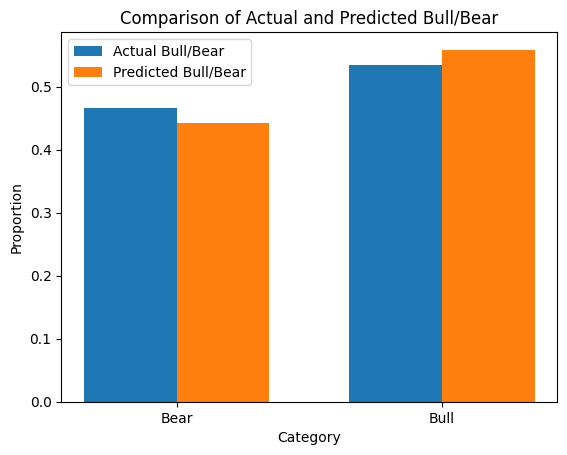

In [29]:
proportion_graph(merged_spy)

###Model 2: Price Prediction

* Training Predictions vs. Observations:

  *   Plots the model's predictions and the actual observed values for the training dataset.
  *   Helps visualize how well the model fits the training data.

* Validation Predictions vs. Observations:

  * Displays the model's predictions and the actual observed values for the validation dataset.
  * Aids in understanding the model's generalization performance on unseen
  
* Testing Predictions vs. Observations:

  * Shows the model's predictions and the actual observed values for the testing dataset.
  * Assists in assessing the model's predictive accuracy on completely new, unseen data (testing set).

* Combined Plot:

  * Combines the training, validation, and testing predictions and observations into a single plot.
  * Offers a comparative view of how well the model performs across different datasets.

####SPY ETF History Chart: 1993 to Present Day

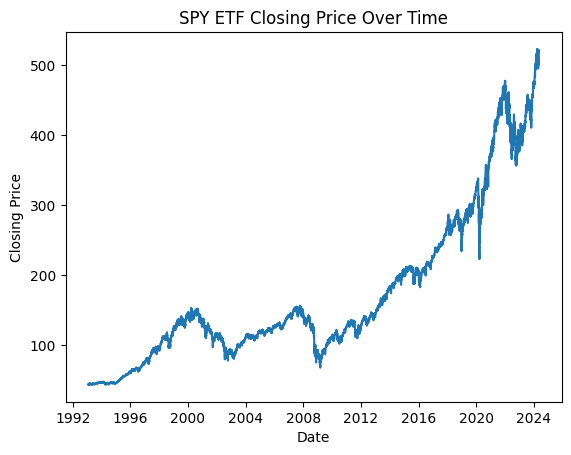

In [30]:
# Closing prices of SPY ETF from 1993 to present day
plt.plot(merged_spy['Dates'], merged_spy['Close'])
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.title('SPY ETF Closing Price Over Time')
plt.show()

####Train, Validation, and Test Split Graph

* Training Data: 80%
* Validation Data: 10%
* Testing Data: 10%


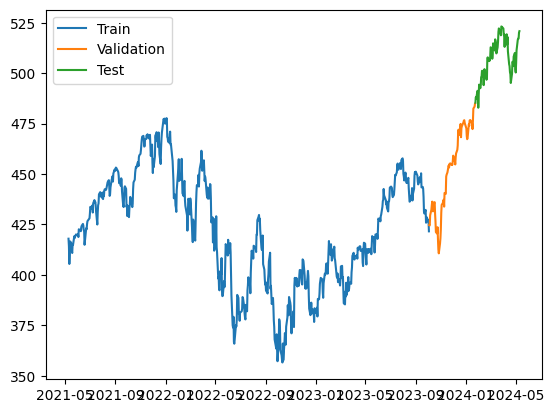

In [31]:
plt.plot(dates_train, y_train)
plt.plot(dates_val, y_val)
plt.plot(dates_test, y_test)

plt.legend(['Train', 'Validation', 'Test'])

####Training Predictions vs. Observations

19/19 [==============================] - 1s 2ms/step


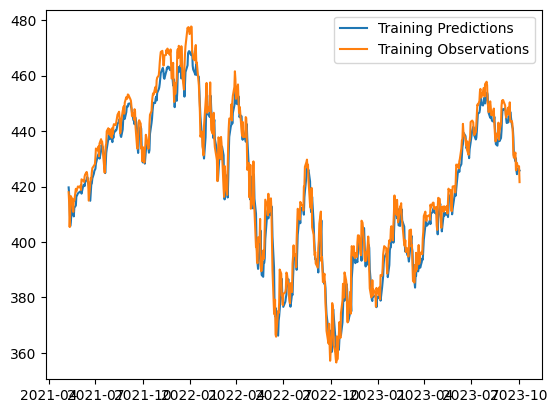

In [32]:
train_predictions = model.predict(X_train).flatten()

plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.legend(['Training Predictions', 'Training Observations'])

####Validation Predictions vs. Observations

3/3 [==============================] - 0s 4ms/step


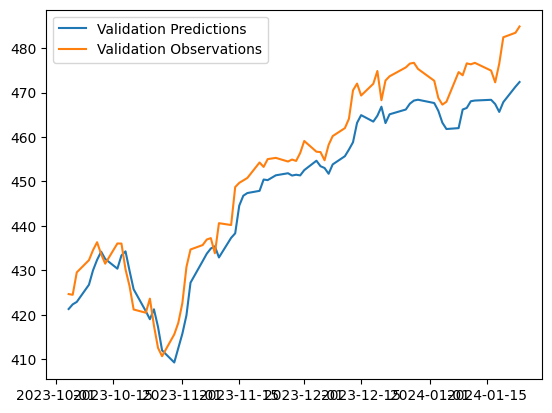

In [33]:
val_predictions = model.predict(X_val).flatten()

plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.legend(['Validation Predictions', 'Validation Observations'])

####Testing Predictions vs. Observations

3/3 [==============================] - 0s 4ms/step


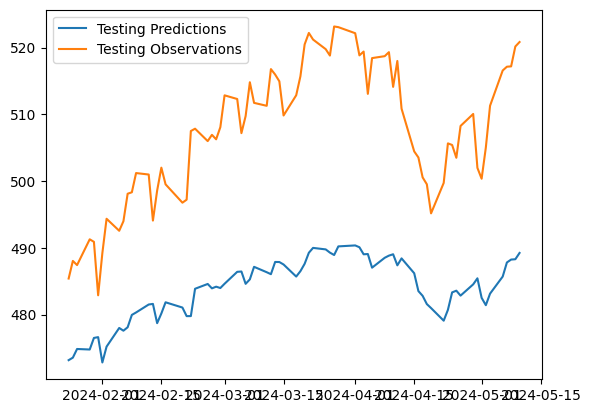

In [34]:
test_predictions = model.predict(X_test).flatten()

plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Testing Predictions', 'Testing Observations'])

####Combined Plot

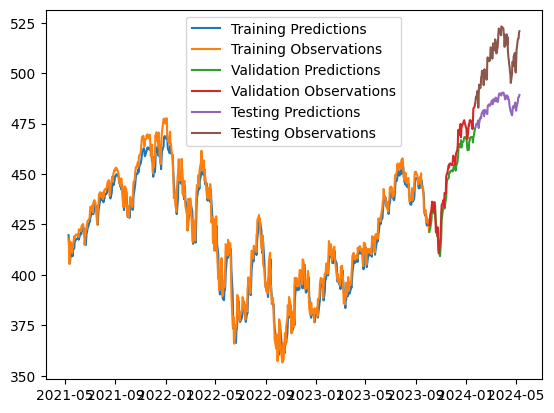

In [35]:
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Training Predictions',
            'Training Observations',
            'Validation Predictions',
            'Validation Observations',
            'Testing Predictions',
            'Testing Observations'])